# Project 1: Implementing and Reproducing the Federated Averaging (FedAvg) Algorithm [100 pts]
In this project, you will partially replicate the experiments from the [FedAvg paper](https://arxiv.org/pdf/1602.05629). Be sure to **store** the intermediate outputs generated while running the cells. Although we will rerun the code to evaluate your final score in top-down fashion, missing outputs may lead to grade reductions. Additionally, since certain hyperparameters were not specified in the original paper, we will use slightly different parameters, which may lead to variations in performance.

Please submit your iPython file named as follows: `'Project1_AIGS_(student_ID)_(your name).ipynb'`. For example, `Project1_AIGS_20225223_Weebum_Yoo.ipynb`.

### Mounting Google Drive (For Google Colab Users Only)
We recommend using local Jupyter Notebook over Google Colab for faster training. However, if you are willing to run experiments in Google Colab, it is essential to save intermediate results to your Google Drive; otherwise, you will have to manually download and upload these results each session.

The code below will mount your Google Drive to the current iPython environment. Do **not** run this code if you are using local Jupyter Notebook.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.makedirs('/content/drive/My Drive/fedavg_results/', exist_ok=True)

### Library Imports  
You can import any additional libraries here, but **DO NOT** include external libraries that have a direct implementation of FedAvg.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt
import pickle

# import additional libraries here if necessary.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = '/content/drive/My Drive/fedavg_results/' if os.path.exists('/content/drive') else ''


### Client Network Declarations
While you may add additional methods and attributes, you shall not modify the existing methods and attributes including the client network architecture and feed forward process.

In [2]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Dataloaders and Data Partitioning Functions (DO NOT Modify)

In [3]:
#----------------DO NOT MODIFY-----------------#

def load_mnist_data():
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    return train_dataset, test_dataset

def create_iid_partitions(dataset, num_clients=100):
    num_items_per_client = len(dataset) // num_clients
    all_indices = np.arange(len(dataset))
    np.random.shuffle(all_indices)

    client_data_indices = {i: all_indices[i * num_items_per_client:(i + 1) * num_items_per_client]
                           for i in range(num_clients)}

    return client_data_indices

def create_non_iid_partitions(dataset, num_clients=100, shards_per_client=2):
    num_shards = num_clients * shards_per_client
    shard_size = len(dataset) // num_shards
    data_indices_by_label = np.argsort(dataset.targets.numpy())

    shards = [data_indices_by_label[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]
    random.shuffle(shards)

    client_data_indices = {}
    for client_id in range(num_clients):
        client_shards = shards[client_id * shards_per_client:(client_id + 1) * shards_per_client]
        client_data_indices[client_id] = np.concatenate(client_shards)

    return client_data_indices

#----------------DO NOT MODIFY-----------------#

- Example usage of 'create_iid_partitions' and create_non_iid_partitions'

In [4]:
train_dataset, test_dataset = load_mnist_data()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1149)>



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:08<00:00, 1157415.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1149)>



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 121481.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1149)>



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:07<00:00, 235087.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1149)>



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4391546.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
num_clients = 100
iid_partitions = create_iid_partitions(train_dataset, num_clients)
non_iid_partitions = create_non_iid_partitions(train_dataset, num_clients)

# Data for client 0 (IID and Non-IID)
client_0_iid_data = torch.utils.data.Subset(train_dataset, iid_partitions[0])
client_0_non_iid_data = torch.utils.data.Subset(train_dataset, non_iid_partitions[0])

# Sanity check
client_0_iid_labels = set([])
for image, label in client_0_iid_data:
    client_0_iid_labels = client_0_iid_labels.union(set([label]))

client_0_non_iid_labels = set([])
for image, label in client_0_non_iid_data:
    client_0_non_iid_labels = client_0_non_iid_labels.union(set([label]))

print(f'Client 0 (IID) data size: {len(client_0_iid_data)}, labels: {client_0_iid_labels}')
print(f'Client 0 (Non-IID) data size: {len(client_0_non_iid_data)}, labels: {client_0_non_iid_labels}')

Client 0 (IID) data size: 600, labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Client 0 (Non-IID) data size: 600, labels: {3, 5}


# Task 1. MNIST Dataset Experiments [70 pts]  



### Task 1-1. Implementing FedAvg Algorithm [10 pts]
In the below cells, you will be finishing writing the incomplete skeleton code for federated averaging on MNIST dataset splits.

#### Definitions on additional functions
Declare additional functions in the below cell necessary for FedAvg algorithm (`federated_avg_mnist`) based on your needs.





In [6]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            output = model(images)
            pred = output.argmax(dim=1)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            total += len(targets)
    return correct / total

# Add additional functions and classes on your needs.
def train_client_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def average_weights(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_model.state_dict()[key].float() for client_model in client_models], 0).mean(0)
    
    global_model.load_state_dict(global_state_dict)
    return global_model

### FedAvg Algorithm on MNIST Dataset Splits
Carefully follow the instructions below. Your implementation of FedAvg will be used to reproduce the experiments and determine your grade on this project. You can begin by **i)** either removing the `raise NotImplementedError` line or **ii)** starting from scratch by deleting the entire skeleton code within the `federated_avg_mnist` function.



### DOs and DON'Ts for your Final Submission:

- **DO NOT** change the `federated_avg` function header.
- **ONLY** use the SGD optimizer for client updates, with the given learning rate (`lr`).
   - Correct: `client_optimizer = optim.SGD(client_model.parameters(), lr=lr)`
   - Incorrect: using Adam, adding momentum, or adjusting the learning rate to anything other than the provided value.
- When `run_to_max_rounds` is set to False, server should stop updating once the `target_accuracy` is reached. If `run_to_max_rounds` is set to True, the server must perform updates for the full `max_rounds` without stopping early, as outlined in the skeleton code.
- The return value **MUST** be a numpy array containing the test accuracies of global models for each round. The array length should match the number of rounds the server has updated.
   - For example, if the server updates for 120 rounds and training stops after reaching the target accuracy (`target_acc`), the array length should be 120, not `max_rounds`.
   - Similarly, if `run_to_max_rounds` is True, the array should have a length equal to `max_rounds`.
- If `verbose` is set to *False*, no logs should be printed. Extra logging when `verbose` is off may result in minor score reductions.


In [7]:
# FedAvg algorithm for MNIST dataset splits
def federated_avg_mnist(global_model, train_dataset, test_dataset, train_dataset_indices, C, E, B, lr, \
                        target_acc=0.99, run_to_max_rounds=False, max_rounds=2000, verbose=False):
    """
    Perform federated averaging.

    :param global_model: Global model to be trained
    :param train_dataset_indices: Data partitioned across clients
    :param C: Fraction of clients per round
    :param E: Number of local epochs per client
    :param B: Batch size for local training
    :param lr: Learning rate for SGD
    :param target_acc: Target accuracy for stopping criterion
    :param run_to_max_rounds: Flag indicating whether to run until maximum rounds (True) or stop at convergence (False)
    :param verbose: Flag managing verbose loggings.

    Modifications to the function header MUST NOT be made in any sense, i.e. do not change any arguments.
    The return value MUST be a numpy array containing test accuracies of global models for each round.
    """

    # An example skeleton code
    selected_clients = max(1, int(C * 100))  # Number of clients selected per round

    test_loader = DataLoader(test_dataset, batch_size=2**12, shuffle=False, pin_memory=True, num_workers=4)
    test_accuracies = []

    for i in range(max_rounds):
        # Randomly select clients, create a new client instance, run local SGD updates on the client's dataset,
        # and gather the updated model weights.
        client_indices = np.random.choice(range(100), selected_clients, replace=False)

        client_models = [MNISTCNN().to(device) for _ in range(selected_clients)]
        for client_model in client_models:
            client_model.load_state_dict(global_model.state_dict())

        for client_id, client_model in zip(client_indices, client_models):
            client_data_indices = train_dataset_indices[client_id]
            train_loader = DataLoader(Subset(train_dataset, client_data_indices), batch_size=B, shuffle=True)
            
            optimizer = optim.SGD(client_model.parameters(), lr=lr)
            train_client_model(client_model, train_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=E)
        
        global_model = average_weights(global_model, client_models)
        
        test_accuracy = evaluate_model(global_model, test_loader)
        if (verbose):
            print(f'Round {i+1}/{max_rounds}, Test Accuracy: {test_accuracy:.4f}')
        test_accuracies.append(test_accuracy)

        if not run_to_max_rounds and test_accuracy >= target_acc:
            return np.array(test_accuracies)

    return np.array(test_accuracies)

### Task 1-2. Evaluating the Effect of Client Portion on Communication Rounds [30 pts]  
Execute the provided code to calculate and evaluate the number of communication rounds needed to achieve the target accuracy (99%) on MNIST dataset splits on varying client portion `C`. Do not alter the below codes in your final submission, and ensure that you do not save any numpy arrays using the same alias as `results_mnist_convergence.npy` outside the below code blocks.

#### Calculating Communication Rounds to Achieve Target Accuracy

Execute the code cell below until the communication rounds for all 10 experimental configurations have been computed.


In [8]:
#----------------DO NOT MODIFY-----------------#

train_dataset, test_dataset = load_mnist_data()
iid_partitions = create_iid_partitions(train_dataset)
non_iid_partitions = create_non_iid_partitions(train_dataset)

rounds_for_convergence = np.zeros((2, 5))
invariant_configs = {'E': 5, 'B': 10, 'lr': 0.1, 'target_acc': 0.99, \
        'train_dataset': train_dataset, 'test_dataset': test_dataset, 'verbose': True}
client_portions = [0.0, 0.1, 0.2, 0.5, 1.0]

training_args = dict(invariant_configs)

if (os.path.exists(f'{save_dir}results_mnist_convergence.npy')):
    try:
        intermediate_results = np.load(f'{save_dir}results_mnist_convergence.npy')
        assert rounds_for_convergence.shape == intermediate_results.shape
        rounds_for_convergence = intermediate_results
    except Exception as e:
        print('Failed on loading intermediate results. Conducting experiments from scratch...')
        print(e)

training_args.update({'train_dataset_indices': iid_partitions})
for i, C in enumerate(client_portions):
    if (rounds_for_convergence[0][i] > 0):
        continue
    print(f'MNIST IID Experiment (C={C})------------------------------------')
    global_model = MNISTCNN().to(device)
    training_args.update({'C': C, 'global_model': global_model})
    rounds_for_convergence[0][i] = len(federated_avg_mnist(**training_args))
    np.save(f'{save_dir}results_mnist_convergence.npy', rounds_for_convergence)

training_args.update({'train_dataset_indices': non_iid_partitions})
for i, C in enumerate(client_portions):
    if (rounds_for_convergence[1][i] > 0):
        continue
    print(f'MNIST non-IID Experiment (C={C})------------------------------------')
    global_model = MNISTCNN().to(device)
    training_args.update({'C': C, 'global_model': global_model})
    rounds_for_convergence[1][i] = len(federated_avg_mnist(**training_args))
    np.save(f'{save_dir}results_mnist_convergence.npy', rounds_for_convergence)

print('All experiments with varying configurations have completed successfully.')

#----------------DO NOT MODIFY-----------------#

MNIST IID Experiment (C=0.0)------------------------------------
Round 1/2000, Test Accuracy: 0.9359
Round 2/2000, Test Accuracy: 0.9459
Round 3/2000, Test Accuracy: 0.9566
Round 4/2000, Test Accuracy: 0.9658
Round 5/2000, Test Accuracy: 0.9656
Round 6/2000, Test Accuracy: 0.9711
Round 7/2000, Test Accuracy: 0.9770
Round 8/2000, Test Accuracy: 0.9742
Round 9/2000, Test Accuracy: 0.9730
Round 10/2000, Test Accuracy: 0.9776
Round 11/2000, Test Accuracy: 0.9807
Round 12/2000, Test Accuracy: 0.9775
Round 13/2000, Test Accuracy: 0.9798
Round 14/2000, Test Accuracy: 0.9792
Round 15/2000, Test Accuracy: 0.9819
Round 16/2000, Test Accuracy: 0.9812
Round 17/2000, Test Accuracy: 0.9826
Round 18/2000, Test Accuracy: 0.9813
Round 19/2000, Test Accuracy: 0.9823
Round 20/2000, Test Accuracy: 0.9820
Round 21/2000, Test Accuracy: 0.9839
Round 22/2000, Test Accuracy: 0.9815
Round 23/2000, Test Accuracy: 0.9838
Round 24/2000, Test Accuracy: 0.9832
Round 25/2000, Test Accuracy: 0.9826
Round 26/2000, Test

#### Result Collection [20 pts]  
Once you have gathered the communication rounds needed for the server network to reach the target accuracy in the previous code cell, execute the code below to summarize the results.

In [9]:
#----------------DO NOT MODIFY-----------------#

print('Effect of the client fraction C on the communication rounds (MNIST, E=5, B=10, target_acc=99%).\n')
print('  Split  | C = 0.0 | C = 0.1 | C = 0.2 | C = 0.5 | C = 1.0 ')
print('-----------------------------------------------------------')
print('   IID   | %7d | %7d | %7d | %7d | %7d ' % tuple(rounds_for_convergence[0]))
print(' non-IID | %7d | %7d | %7d | %7d | %7d ' % tuple(rounds_for_convergence[1]))

#----------------DO NOT MODIFY-----------------#

Effect of the client fraction C on the communication rounds (MNIST, E=5, B=10, target_acc=99%).

  Split  | C = 0.0 | C = 0.1 | C = 0.2 | C = 0.5 | C = 1.0 
-----------------------------------------------------------
   IID   |      75 |      25 |      24 |      24 |      25 
 non-IID |     869 |     135 |     111 |     131 |     110 


#### Discussion [10 pts]
Based on the results shown in the table above, write a brief one-paragraph discussion analyzing the effects of changing the client portion (`C`) on the communication rounds required to achieve target accuracy.

**Discussion:** (Insert your discussion here.)

The table shows that increasing the client portion (C) reduces the communication rounds required to achieve the target accuracy of 99% in both IID and non-IID data splits, but the impact is more pronounced in non-IID settings. In IID data, where data is uniformly distributed among clients, the rounds required for convergence stabilize quickly, with values around 24 to 25 rounds regardless of C. However, in non-IID data splits, where data distribution is skewed across clients, a low client portion (C = 0.0) leads to a high number of communication rounds (869) due to the lack of data diversity per round, causing slower model convergence. As C increases from 0.1 to 1.0 in the non-IID scenario, the communication rounds needed to reach the target accuracy decrease substantially, from 135 to 110, as more clients contribute data per round, mitigating the challenges of non-uniform data distribution. Therefore, the results indicate that a higher client portion accelerates convergence significantly, especially in non-IID scenarios where data diversity is limited across individual clients.

### Task 1-3. Evaluating the Effect of Varying Local Batch Size and Epochs (MNIST, IID Partitions) [30 pts]

In this task, server updates will be performed for `max_rounds`, unlike the previous experiments where training ended upon reaching the target accuracy. You will generate accuracy curves for each configuration. Analogous to the previous task, you should not save pickle files using the same alias as `results_mnist_iid_accuracy_curve.pickle` outside the below code blocks.


#### Accuracy Calculation

Run the code cell below to compute accuracies up to `max_rounds` for various configurations of local batch size (`B`) and epochs (`E`).
Like

In [10]:
#----------------DO NOT MODIFY-----------------#

train_dataset, test_dataset = load_mnist_data()
iid_partitions = create_iid_partitions(train_dataset)

invariant_configs = {'C': 0.1, 'lr': 0.1, 'run_to_max_rounds': True, 'max_rounds': 400, \
        'train_dataset': train_dataset, 'test_dataset': test_dataset, 'verbose': True}
variant_configs = [{'B': 10, 'E': 1}, {'B': 10, 'E': 20}, {'B': 50, 'E': 1}, {'B': 50, 'E': 20}, \
        {'B': 600, 'E': 1}, {'B': 600, 'E': 20}]

mnist_accuracy_curves = dict()
training_args = dict(invariant_configs)
generate_string = lambda d: ' '.join(['%s=%d' % (key, value) for key, value in d.items()])

if (os.path.exists(f'{save_dir}results_mnist_iid_accuracy_curve.pickle')):
    try:
        with open(f'{save_dir}results_mnist_iid_accuracy_curve.pickle', 'rb') as f:
            mnist_accuracy_curves = pickle.load(f)
    except Exception as e:
        print('Failed on loading intermediate results. Conducting experiments from scratch...')
        print(e)

training_args.update({'train_dataset_indices': iid_partitions})
for variant_config in variant_configs:
    global_model = MNISTCNN().to(device)
    training_args.update(variant_config)
    training_args.update({'global_model': global_model})

    config_name = generate_string(variant_config)
    if (config_name in mnist_accuracy_curves.keys() and len(mnist_accuracy_curves[config_name]) == 400):
        continue

    print(f'MNIST IID Experiment ({config_name})--------------------------------')
    mnist_accuracy_curves[config_name] = federated_avg_mnist(**training_args)
    with open(f'{save_dir}results_mnist_iid_accuracy_curve.pickle', 'wb') as f:
        pickle.dump(mnist_accuracy_curves, f)

print('All experiments with varying configurations have completed successfully.')

#----------------DO NOT MODIFY-----------------#

MNIST IID Experiment (B=10 E=1)--------------------------------
Round 1/400, Test Accuracy: 0.8119
Round 2/400, Test Accuracy: 0.8968
Round 3/400, Test Accuracy: 0.9377
Round 4/400, Test Accuracy: 0.9455
Round 5/400, Test Accuracy: 0.9584
Round 6/400, Test Accuracy: 0.9629
Round 7/400, Test Accuracy: 0.9683
Round 8/400, Test Accuracy: 0.9694
Round 9/400, Test Accuracy: 0.9705
Round 10/400, Test Accuracy: 0.9752
Round 11/400, Test Accuracy: 0.9775
Round 12/400, Test Accuracy: 0.9778
Round 13/400, Test Accuracy: 0.9792
Round 14/400, Test Accuracy: 0.9795
Round 15/400, Test Accuracy: 0.9807
Round 16/400, Test Accuracy: 0.9813
Round 17/400, Test Accuracy: 0.9822
Round 18/400, Test Accuracy: 0.9815
Round 19/400, Test Accuracy: 0.9823
Round 20/400, Test Accuracy: 0.9827
Round 21/400, Test Accuracy: 0.9829
Round 22/400, Test Accuracy: 0.9848
Round 23/400, Test Accuracy: 0.9858
Round 24/400, Test Accuracy: 0.9851
Round 25/400, Test Accuracy: 0.9852
Round 26/400, Test Accuracy: 0.9855
Round 27/

#### Accuracy Curve Plotting [20 pts]  
Once you have gathered the necessary results in the previous code cell, execute the code below to summarize the results.

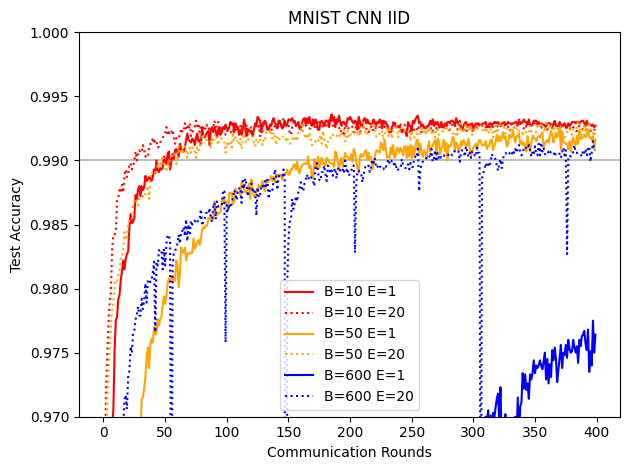

<Figure size 640x480 with 0 Axes>

In [11]:
#----------------DO NOT MODIFY-----------------#

plot_configs = {
    'B=10 E=1': {'color': 'red', 'linestyle': '-', 'label': 'B=10 E=1'},
    'B=10 E=20': {'color': 'red', 'linestyle': ':', 'label': 'B=10 E=20'},
    'B=50 E=1': {'color': 'orange', 'linestyle': '-', 'label': 'B=50 E=1'},
    'B=50 E=20': {'color': 'orange', 'linestyle': ':', 'label': 'B=50 E=20'},
    'B=600 E=1': {'color': 'blue', 'linestyle': '-', 'label': 'B=600 E=1'},
    'B=600 E=20': {'color': 'blue', 'linestyle': ':', 'label': 'B=600 E=20'},
}

plt.axhline(y=0.99, color='gray', linestyle='-', alpha=0.5)

for config, accuracies in mnist_accuracy_curves.items():
    if config in plot_configs:
        cfg = plot_configs[config]
        plt.plot(accuracies, color=cfg['color'], linestyle=cfg['linestyle'], label=cfg['label'])

plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.title('MNIST CNN IID')
plt.ylim(0.97, 1.0)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('mnist_iid_accuracy_curves.png')

#----------------DO NOT MODIFY-----------------#

#### Discussion [10 pts]
Based on the results shown in the figure above, write a brief discussion analyzing the effects of changing the local batch size (`B`) and epochs (`E`) on the communication rounds required to achieve target accuracy.

**Discussion:** (Insert your discussion here.)

The graph demonstrates how varying the local batch size (B) and the number of local epochs (E) impacts the communication rounds needed to reach a high test accuracy for an IID MNIST dataset in a federated learning setup. Lower batch sizes (e.g., B=10) lead to faster convergence, particularly when combined with fewer epochs (e.g., E=1). This combination (red solid line) achieves target accuracy quickly within about 50 rounds. However, increasing the batch size (e.g., B=600) or the number of epochs (e.g., E=20) generally slows down convergence, requiring more rounds to reach the same accuracy level. For instance, the configuration, B=600,E=20 (blue dotted line) struggles to reach the 99% accuracy level even after 400 rounds. The impact of increasing epochs appears to be more significant with larger batch sizes, potentially due to overfitting on limited batches in each local update, which reduces generalization to the global model. In summary, smaller batch sizes and fewer epochs promote faster convergence, while larger batch sizes and more local epochs require substantially more communication rounds to achieve similar accuracy.

### Task 1-4. (*Extra Credit) Evaluating the Impact of Varying Local Batch Size and Epochs (MNIST, non-IID Partitions) [+10 pts]

This task is similar to the previous one, but this time uses non-IID partitions of the MNIST dataset, and the maximum number of rounds (`max_rounds`) has been increased from 400 to 1000. While the code will run without issues, the training time will be approximately 2.5 times longer than in the previous task. Therefore, it is highly recommended to complete this section *after* finishing the other tasks.


#### Accuracy Calculation

Run the code cell below to compute accuracies up to `max_rounds` for various configurations of local batch size (`B`) and epochs (`E`).
Like

In [12]:
#----------------DO NOT MODIFY-----------------#

train_dataset, test_dataset = load_mnist_data()
non_iid_partitions = create_non_iid_partitions(train_dataset)

invariant_configs = {'C': 0.1, 'lr': 0.1, 'run_to_max_rounds': True, 'max_rounds': 1000, \
        'train_dataset': train_dataset, 'test_dataset': test_dataset, 'verbose': True}
variant_configs = [{'B': 10, 'E': 1}, {'B': 10, 'E': 20}, {'B': 50, 'E': 1}, {'B': 50, 'E': 20}, \
        {'B': 600, 'E': 1}, {'B': 600, 'E': 20}]

mnist_accuracy_curves = dict()
training_args = dict(invariant_configs)

if (os.path.exists(f'{save_dir}results_mnist_non_iid_accuracy_curve.pickle')):
    try:
        with open(f'{save_dir}results_mnist_non_iid_accuracy_curve.pickle', 'rb') as f:
            mnist_accuracy_curves = pickle.load(f)
    except Exception as e:
        print('Failed on loading intermediate results. Conductin experiments from scratch...')
        print(e)

training_args.update({'train_dataset_indices': non_iid_partitions})
for variant_config in variant_configs:
    global_model = MNISTCNN().to(device)
    training_args.update(variant_config)
    training_args.update({'global_model': global_model})

    config_name = generate_string(variant_config)
    if (config_name in mnist_accuracy_curves.keys() and len(mnist_accuracy_curves[config_name]) == 1000):
        continue

    print(f'MNIST non-IID Experiment ({config_name})--------------------------------')
    mnist_accuracy_curves[config_name] = federated_avg_mnist(**training_args)
    with open(f'{save_dir}results_mnist_non_iid_accuracy_curve.pickle', 'wb') as f:
        pickle.dump(mnist_accuracy_curves, f)

print('All experiments with varying configurations have completed successfully.')

#----------------DO NOT MODIFY-----------------#

MNIST non-IID Experiment (B=10 E=1)--------------------------------
Round 1/1000, Test Accuracy: 0.2794
Round 2/1000, Test Accuracy: 0.3379
Round 3/1000, Test Accuracy: 0.4879
Round 4/1000, Test Accuracy: 0.6257
Round 5/1000, Test Accuracy: 0.6659
Round 6/1000, Test Accuracy: 0.7020
Round 7/1000, Test Accuracy: 0.6674
Round 8/1000, Test Accuracy: 0.7739
Round 9/1000, Test Accuracy: 0.8258
Round 10/1000, Test Accuracy: 0.8199
Round 11/1000, Test Accuracy: 0.8667
Round 12/1000, Test Accuracy: 0.8569
Round 13/1000, Test Accuracy: 0.8418
Round 14/1000, Test Accuracy: 0.9058
Round 15/1000, Test Accuracy: 0.9003
Round 16/1000, Test Accuracy: 0.9185
Round 17/1000, Test Accuracy: 0.9358
Round 18/1000, Test Accuracy: 0.9322
Round 19/1000, Test Accuracy: 0.9477
Round 20/1000, Test Accuracy: 0.9159
Round 21/1000, Test Accuracy: 0.9197
Round 22/1000, Test Accuracy: 0.9358
Round 23/1000, Test Accuracy: 0.9413
Round 24/1000, Test Accuracy: 0.9579
Round 25/1000, Test Accuracy: 0.9553
Round 26/1000, T

#### Accuracy Curve Plotting [+10 pts]  
Once you have gathered the necessary results in the previous code cell, execute the code below to summarize the results.

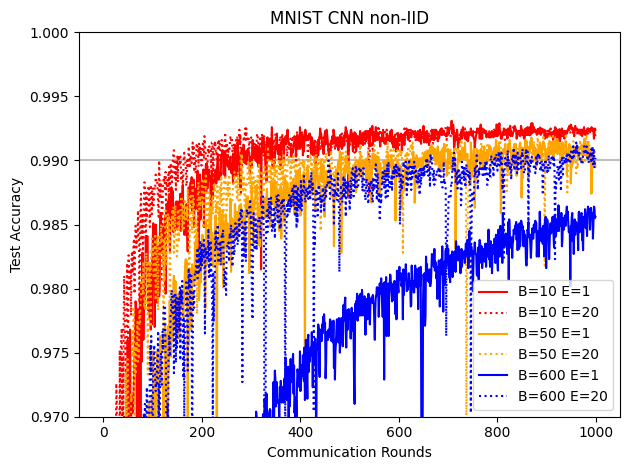

<Figure size 640x480 with 0 Axes>

In [13]:
#----------------DO NOT MODIFY-----------------#

plt.figure()
plot_configs = {
    'B=10 E=1': {'color': 'red', 'linestyle': '-', 'label': 'B=10 E=1'},
    'B=10 E=20': {'color': 'red', 'linestyle': ':', 'label': 'B=10 E=20'},
    'B=50 E=1': {'color': 'orange', 'linestyle': '-', 'label': 'B=50 E=1'},
    'B=50 E=20': {'color': 'orange', 'linestyle': ':', 'label': 'B=50 E=20'},
    'B=600 E=1': {'color': 'blue', 'linestyle': '-', 'label': 'B=600 E=1'},
    'B=600 E=20': {'color': 'blue', 'linestyle': ':', 'label': 'B=600 E=20'},
}

plt.axhline(y=0.99, color='gray', linestyle='-', alpha=0.5)

for config, accuracies in mnist_accuracy_curves.items():
    if config in plot_configs:
        cfg = plot_configs[config]
        plt.plot(accuracies, color=cfg['color'], linestyle=cfg['linestyle'], label=cfg['label'])

plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.title('MNIST CNN non-IID')
plt.ylim(0.97, 1.0)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('mnist_non_iid_accuracy_curves.png')

#----------------DO NOT MODIFY-----------------#

# Task 2. CIFAR-10 Experiments [30 pts]

### Task 2-1. Implementing FedAvg Algorithm [10 pts]
In the below cells, you will be finishing writing the incomplete skeleton code for federated averaging on CIFAR dataset splits.

#### Definitions on additional functions
Declare additional functions in the below cell necessary for FedAvg algorithm (`federated_avg_cifar10`) based on your needs.





In [70]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return correct / total

#### FedAvg Algorithm on CIFAR-10 Dataset Splits [10 pts]
The instructions in Task 1-1's cell mostly applies the same. However in this case, you will need to reduce the learning rate(`lr`) by 0.99 per round (i.e. learning rate decay by 0.99) as provided in the skeleton code. You can begin by either removing the `raise NotImplementedError` line or starting from scratch by deleting the entire skeleton code within the `federated_avg_cifar10` function.

In [71]:
# Federated Averaging algorithm (FedAvg)
def federated_avg_cifar10(global_model, train_dataset, test_dataset, train_dataset_indices, C, E, B, lr, \
        target_acc=0.99, run_to_max_rounds=False, max_rounds=2000, verbose=False):
    """
    Perform federated averaging.

    :param global_model: Global model to be trained
    :param train_dataset_indices: Data partitioned across clients
    :param C: Fraction of clients per round
    :param E: Number of local epochs per client
    :param B: Batch size for local training
    :param lr: Learning rate for SGD
    :param target_acc: Target accuracy for stopping criterion
    :param run_to_max_rounds: Flag indicating whether to run until maximum rounds (True) or stop at convergence (False)
    :param verbose: Flag managing verbose loggings.

    Modifications to the function header MUST NOT be made in any sense, i.e. do not change any arguments.
    The return value MUST be a numpy array containing test accuracies of global models for each round.

    Unlike FedAvg experiments on MNIST, this time reduce learning rate by 0.99 per round (i.e. lr decay by 0.995).
    """
    selected_clients = max(1, int(C * 100))  # Number of clients selected per round

    test_loader = DataLoader(test_dataset, batch_size=2**12, shuffle=False, pin_memory=True, num_workers=4)
    test_accuracies = []

    for i in range(max_rounds):
        # Randomly select clients, create a new client instance, run local SGD updates on the client's dataset,
        # and gather the updated model weights.
        client_indices = np.random.choice(range(100), selected_clients, replace=False)

        client_models = [CIFAR10CNN().to(device) for _ in range(selected_clients)]
        for client_model in client_models:
            client_model.load_state_dict(global_model.state_dict())

        for client_id, client_model in zip(client_indices, client_models):
            client_data_indices = train_dataset_indices[client_id]
            train_loader = DataLoader(Subset(train_dataset, client_data_indices), batch_size=B, shuffle=True)
            
            optimizer = optim.SGD(client_model.parameters(), lr=lr)
            train_client_model(client_model, train_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=E)
        
        global_model = average_weights(global_model, client_models)
    
        test_accuracy = evaluate_model(global_model, test_loader)
        if (verbose):
            print(f'Round {i+1}/{max_rounds}, Test Accuracy: {test_accuracy:.4f}')
        test_accuracies.append(test_accuracy)

        if not run_to_max_rounds and test_accuracy >= target_acc:
            return np.array(test_accuracies)

        lr *= 0.99

    return np.array(test_accuracies)

In [72]:
#----------------DO NOT MODIFY-----------------#
def load_cifar10_data():
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor()])
    test_transform = transforms.ToTensor()
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    return train_dataset, test_dataset

train_dataset, test_dataset = load_cifar10_data()
#----------------DO NOT MODIFY-----------------#

Files already downloaded and verified
Files already downloaded and verified


### Task 2-2. Evaluating the Effect of Learning Rate (CIFAR-10, IID Partitions) [20 pts]  
Execute the provided code to calculate and evaluate the number of communication rounds needed to achieve the target accuracy (99%) on MNIST dataset splits on varying client portion `C`. Do not alter the below codes in your final submission, and ensure that you do not save any numpy arrays using the same alias as `results_mnist_convergence.npy` outside the below code blocks.

#### Accuracy Calculation

Run the code cell below to compute accuracies up to `max_rounds` for different configurations of learning rates (`lr`).

In [73]:
#----------------DO NOT MODIFY-----------------#
invariant_configs = {'C': 0.1, 'B': 50, 'E': 5, 'run_to_max_rounds': True, 'max_rounds': 1000, \
        'train_dataset': train_dataset, 'test_dataset': test_dataset, 'verbose': True}
variant_configs = [{'lr': 0.05}, {'lr': 0.15}, {'lr': 0.25}]

cifar10_accuracy_curves = dict()
training_args = dict(invariant_configs)

if (os.path.exists(f'{save_dir}results_cifar10_iid_accuracy_curve.pickle')):
    try:
        with open(f'{save_dir}results_cifar10_iid_accuracy_curve.pickle', 'rb') as f:
            cifar10_accuracy_curves = pickle.load(f)
    except Exception as e:
        print('Failed on loading intermediate results. Conductin experiments from scratch...')
        print(e)

iid_partitions = create_iid_partitions(train_dataset)
generate_string = lambda d: ' '.join(['%s=%.2f' % (key, value) for key, value in d.items()])
training_args.update({'train_dataset_indices': iid_partitions})
for variant_config in variant_configs:
    global_model = CIFAR10CNN().to(device)
    training_args.update(variant_config)
    training_args.update({'global_model': global_model})

    config_name = generate_string(variant_config)
    if (config_name in cifar10_accuracy_curves.keys() and len(cifar10_accuracy_curves[config_name]) == 1000):
        continue

    print(f'CIFAR10 IID Experiment ({config_name})--------------------------------')
    cifar10_accuracy_curves[config_name] = federated_avg_cifar10(**training_args)
    with open(f'{save_dir}results_cifar10_iid_accuracy_curve.pickle', 'wb') as f:
        pickle.dump(cifar10_accuracy_curves, f)

print('All experiments with varying configurations have completed successfully.')
#----------------DO NOT MODIFY-----------------#

CIFAR10 IID Experiment (lr=0.05)--------------------------------
Round 1/1000, Test Accuracy: 0.1219
Round 2/1000, Test Accuracy: 0.1850
Round 3/1000, Test Accuracy: 0.2395
Round 4/1000, Test Accuracy: 0.2670
Round 5/1000, Test Accuracy: 0.2824
Round 6/1000, Test Accuracy: 0.3095
Round 7/1000, Test Accuracy: 0.3346
Round 8/1000, Test Accuracy: 0.3459
Round 9/1000, Test Accuracy: 0.3605
Round 10/1000, Test Accuracy: 0.3785
Round 11/1000, Test Accuracy: 0.3870
Round 12/1000, Test Accuracy: 0.3935
Round 13/1000, Test Accuracy: 0.4035
Round 14/1000, Test Accuracy: 0.4098
Round 15/1000, Test Accuracy: 0.4239
Round 16/1000, Test Accuracy: 0.4230
Round 17/1000, Test Accuracy: 0.4331
Round 18/1000, Test Accuracy: 0.4321
Round 19/1000, Test Accuracy: 0.4491
Round 20/1000, Test Accuracy: 0.4588
Round 21/1000, Test Accuracy: 0.4667
Round 22/1000, Test Accuracy: 0.4696
Round 23/1000, Test Accuracy: 0.4751
Round 24/1000, Test Accuracy: 0.4767
Round 25/1000, Test Accuracy: 0.4779
Round 26/1000, Test

#### Accuracy Curve Plotting [10 pts]  
Once you have gathered the necessary results in the previous code cell, execute the code below to summarize the results.

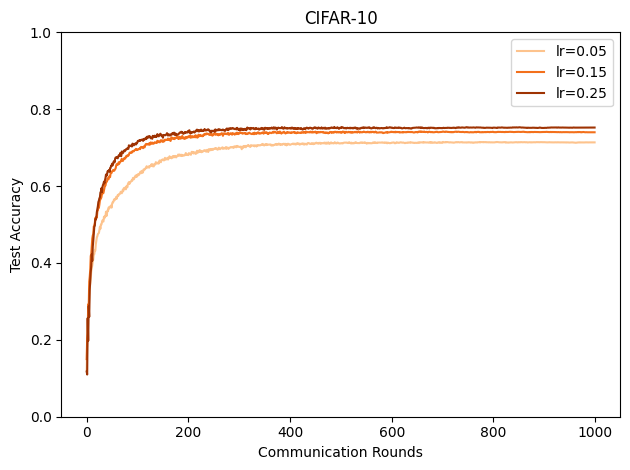

<Figure size 640x480 with 0 Axes>

In [74]:
#----------------DO NOT MODIFY-----------------#
plt.figure()
orange_cmap = plt.get_cmap('Oranges')
plot_configs = {
    'lr=0.05': {'color': orange_cmap(0.3), 'linestyle': '-', 'label': 'lr=0.05'},
    'lr=0.15': {'color': orange_cmap(0.6), 'linestyle': '-', 'label': 'lr=0.15'},
    'lr=0.25': {'color': orange_cmap(0.9), 'linestyle': '-', 'label': 'lr=0.25'},
}

for config, accuracies in cifar10_accuracy_curves.items():
    if config in plot_configs:
        cfg = plot_configs[config]
        plt.plot(accuracies, color=cfg['color'], linestyle=cfg['linestyle'], label=cfg['label'])

plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.title('CIFAR-10')
plt.ylim(0.0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('cifar10_iid_accuracy_curves.png')
#----------------DO NOT MODIFY-----------------#

#### Discussion [10 pts]
Based on the results shown in the figure above, write a brief discussion analyzing the effects of changing the learning rates (`lr`).

**Discussion:** (Insert your discussion here.)

The result illustrates the effect of different learning rates on the performance of federated learning for CIFAR-10. With a learning rate of 0.05, the convergence rate is relatively slow, and the final test accuracy is lower compared to higher learning rates. For the learning rate of 0.15, the model exhibits a more balanced performance. It achieves a quicker convergence compared to 0.05, and the final test accuracy is higher. This suggests that a moderate learning rate can maintain training stability while still achieving efficient convergence. The learning rate of 0.25 shows the fastest initial convergence and reaches a high level of test accuracy more quickly. However, while it converges faster, there may be risks of oscillation or instability, especially in the later stages of training. Nonetheless, in this experiment, learning rates of 0.15 and 0.25 demonstrate very similar final accuracies, with 0.25 reaching the target performance quicker. Overall, learning rates of 0.15 and 0.25 provide better performance in terms of achieving higher accuracy and faster training compared to 0.05.